<a href="https://colab.research.google.com/github/parthatom/UnsupervisedClassification/blob/master/UnSupervisedLearning_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essentials


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def gini(array):
    """
    Calculate the Gini coefficient of a numpy array.
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [0]:
import tqdm
from tqdm import tqdm

# Unsupervised Learning on Synthetic Sparse and Uniform Data

## Importing

In [0]:
import torch
import torchvision
import sys
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
colors = ['y', 'r']

In [0]:
def n_weight(x, db):
  xp = np.matmul(np.transpose(x), x)
  npow = xp * pow(10, -0.1*db)
  return npow.item()

In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
class Metrics():
  def __init__(self):
    self.nmi = normalized_mutual_info_score
    self.ari = adjusted_rand_score


  def acc(self, y_true, y_pred):
      """
      Calculate clustering accuracy. Require scikit-learn installed
      # Arguments
          y: true labels, numpy.array with shape `(n_samples,)`
          y_pred: predicted labels, numpy.array with shape `(n_samples,)`
      # Return
          accuracy, in [0,1]
      """
      y_true = y_true.astype(np.int64)
      assert y_pred.size == y_true.size
      D = max(y_pred.max(), y_true.max()) + 1
      w = np.zeros((D, D), dtype=np.int64)
      for i in range(y_pred.size):
          w[y_pred[i], y_true[i]] += 1
      from sklearn.utils.linear_assignment_ import linear_assignment
      ind = linear_assignment(w.max() - w)
      return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [7]:
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import mixture
import torchvision.transforms as transforms
from torchvision import models
from keras.utils import normalize
import time
from sklearn.cluster import SpectralClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2
import pickle
metrics = Metrics()


Using TensorFlow backend.


In [8]:
time.time()

1577089485.6077058

In [0]:
!mkdir /content/drive/'My Drive'/Outputs/Synthetic_Unsupervised/UnSorted/threed

In [0]:
gmm_path = Path('/', 'content', 'drive', 'My Drive', 'Outputs','Synthetic_Unsupervised','Sorted', 'GMMs')
kmeans_path = Path('/', 'content', 'drive','My Drive', 'Outputs', 'Synthetic_Unsupervised','Sorted','KMeans')

In [0]:
synthetic_path = Path('/', 'content','drive', "My Drive", 'Outputs', 'Synthetic_Unsupervised','UnSorted', 'threed')

## Data Creation

In [10]:
seed = 42
torch.random.manual_seed(seed)

### Concat and Shuffle

In [0]:
def synth_data(sparsity = 1, std =  0.01, sparse = True): 
  if(sparse):
    print("Creating Sparse Data")
    X = torch.zeros((5001,39))
    for j in range(len(X)):
      perm1 = torch.randperm(39)
      for i in range(sparsity):
        X[j][int(perm1[i].item())] = 1
  else:
    print("Creating Uniform data")
    X = torch.ones((5001, 39))
    for j in range(len(X)):
      perm1 = torch.randperm(39)
      for i in range(sparsity-1):
        X[j][int(perm1[i].item())] = 0
  # X,c = torch.sort(X, dim = 0)
  noise = torch.randn((5001,39))
  noisy_X = X+ std*noise
  noisy_X = torch.abs(noisy_X)
  noisy_X = noisy_X/(torch.sum(noisy_X, dim = 1).view(-1,1))
  # noisy_X, c = torch.sort(noisy_X, dim = 1)
  return noisy_X

In [0]:
def create_data(sparsity = 1, std = 0.01):
  un = synth_data(sparsity= sparsity, std = std, sparse = False)
  sp = synth_data(sparsity = sparsity, std = std, sparse = True)
  X = torch.cat((un,sp), dim = 0)
  o = torch.ones((5001,1))
  z = torch.zeros((5001,1))
  labels = torch.cat((o,z), dim = 0)
  perm = torch.randperm(10002)
  X = X[perm]
  labels = labels[perm]
  return X, labels

In [0]:
def synther(sparsity = 1, std = 0.01, sparse = True):
  if sparse:
    X = np.zeros((5001, 3))
    for j in range(len(X)):
      perm1 = np.random.permutation(3)
      for i in range(sparsity):
        X[j][int(perm1[i].item())] = 1
  else:
    X = np.ones((5001, 3))
    for j in range(len(X)):
      perm1 = np.random.permutation(3)
      for i in range(sparsity-1):
        X[j][int(perm1[i].item())] = 0
  noise = np.random.multivariate_normal(mean = np.zeros((3,)), cov = np.identity(3), size = 5001)
  noisy_X = X + std * noise
  noisy_X = np.abs(noisy_X)
  noisy_X = noisy_X/(np.sum(noisy_X, axis = 1).reshape(-1,1))
  return noisy_X

In [0]:
def creater(sparsity = 1, std = 0.01):
  un = synther(sparsity= sparsity, std = std, sparse = False)
  sp = synther(sparsity = sparsity, std = std, sparse = True)
  X = np.concatenate((un,sp), axis = 0)
  o = np.ones((5001,1))
  z = np.zeros((5001,1))
  labels = np.concatenate((o,z), axis = 0)
  perm = np.random.permutation(10002)
  X = X[perm]
  labels = labels[perm]
  return X, labels

In [15]:
a = creater()
X = a[0]
y = a[1]
print(X.shape)
print([(gini(X[i]),i) for i in range(600, 604)])
print(X[600:604])
y[600:604]

(10002, 3)
[(0.6624605750037831, 600), (0.6544327489527978, 601), (0.004423251530483319, 602), (0.0030269858240447394, 603)]
[[4.60717338e-03 8.50833006e-04 9.94541994e-01]
 [9.86040776e-01 4.39135768e-03 9.56786672e-03]
 [3.35800286e-01 3.35034306e-01 3.29165407e-01]
 [3.31710144e-01 3.36250624e-01 3.32039231e-01]]


array([[0.],
       [0.],
       [1.],
       [1.]])

In [0]:
a = create_data(sparsity = 1, std = 0.01)
X = a[0]
labels = a[1]
# np.save(os.path.join(synthetic_path, 'X.npy'), X)
# np.save(os.path.join(synthetic_path, 'y.npy'), labels)
print(X.shape)
print([(gini(X[i].numpy()),i) for i in range(600, 604)])
print(X[600:604])
print(torch.sum(X, dim = 1).shape)
labels[600:604]

Creating Uniform data
Creating Sparse Data
torch.Size([10002, 39])
[(0.8576756296428034, 600), (0.8443128085249886, 601), (0.8362271833712025, 602), (0.0051528526598937285, 603)]
tensor([[6.1154e-03, 2.2383e-03, 2.3308e-03, 7.5148e-04, 1.0912e-02, 1.1380e-03,
         6.1434e-03, 1.5088e-02, 1.4834e-03, 1.1653e-03, 2.2318e-04, 1.1667e-02,
         5.0498e-03, 1.0897e-02, 4.4838e-03, 1.3630e-02, 2.1431e-04, 1.6396e-03,
         1.1606e-02, 2.3568e-03, 5.3922e-04, 1.5772e-02, 1.3440e-02, 7.8796e-01,
         2.3151e-03, 4.7150e-03, 3.3083e-03, 2.7110e-03, 1.1520e-03, 1.2431e-03,
         9.1522e-03, 6.7084e-03, 5.6628e-03, 1.3303e-02, 2.0920e-03, 8.9156e-03,
         2.4407e-03, 4.6738e-03, 4.7579e-03],
        [2.9500e-03, 6.3560e-03, 6.0568e-03, 5.1437e-03, 1.3741e-03, 4.1332e-03,
         7.4292e-03, 1.2413e-02, 6.8135e-03, 4.7363e-03, 3.5830e-03, 9.4331e-03,
         5.6441e-03, 5.1158e-03, 5.7320e-03, 3.7166e-04, 1.3555e-03, 9.1325e-03,
         2.5788e-03, 2.7114e-03, 3.6652e-03, 8

tensor([[0.],
        [0.],
        [0.],
        [1.]])

## GMMs

### Model

In [0]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = ['y', 'r']
%matplotlib inline

In [0]:
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
metrics = Metrics()

In [0]:
def Autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)
        x = BatchNormalization()(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
        x = BatchNormalization()(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [0]:
n_clusters = 2

In [0]:
dims = [X.shape[-1], 500, 500, 2000, 2]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = Adam(lr=0.001 )
pretrain_epochs = 30
batch_size = 256
save_dir = synthetic_path

In [0]:
lrs = [3e-5, 2.25e-5, 1.68e-5, 1.27e-5, 1e-5 ]
batch_sizes = [64, 72, 82, 100, 113, 128]
epochs = [5, 5, 10, 10]

In [0]:
len(lrs)

6

In [0]:
accuracy_tuning = np.zeros((len(lrs), len(batch_sizes), len(epochs)))
loss_tuning = np.zeros((len(lrs), len(batch_sizes), len(epochs)))
accuracy_tuning.shape

(6, 5, 4)

In [0]:
db = 9
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_db_{db}.npy'))
y = np.load(os.path.join(synthetic_path, f"labels_sparsity_1_db_{db}.npy"))

In [0]:
history_list = []
for i,lr in enumerate(lrs):
  for j,batch_size in enumerate(batch_sizes):
    autoencoder, encoder = Autoencoder(dims, init=init)
    pretrain_optimizer = Adam(lr=lr)    
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    
    for k,pretrain_epochs in enumerate(epochs): 
      total_trained = 0     
      b = autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
      history_list.append(b)
      loss_tuning[i][j][k] = (b.history['loss'])[-1]
      autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}_lr_{lr}_batch_size_{batch_size}_epochs_{pretrain_epochs+total_trained}.h5"))
      total_trained = pretrain_epochs
      encoding = encoder.predict(X)      

      kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
      y_pred_ae_means = kmeans.labels_
      del kmeans

      accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
      print("accuracy",lr,batch_size, pretrain_epochs, accs_ae_means)
      accuracy_tuning[i][j][k] = accs_ae_means
      del y_pred_ae_means, accs_ae_means
    del autoencoder, encoder, pretrain_optimizer
np.save(os.path.join(synthetic_path, f'accuracy_tuning_sparsity_1_db_{db}.npy'), accuracy_tuning)
np.save(os.path.join(synthetic_path, f'loss_tuning_sparsity_1_db_{db}.npy'), loss_tuning)

In [0]:
loss_dict = dict((lr,dict((batch_size, dict((epoch, loss_tuning[i][j][k]) for k,epoch in enumerate(epochs))) for j, batch_size in enumerate(batch_sizes ))) for i, lr in enumerate(lrs)) 
# accuracy_dict = dict((lr,dict((batch_size, accuracy_tuning[j][i]) for i, batch_size in enumerate(batch_sizes ))) for j, lr in enumerate(lrs)) 

In [0]:
lr_index = 5
fig, ax = plt.subplots()
im = ax.imshow(accuracy_tuning[lr_index])

# We want to show all ticks...
ax.set_xticks(np.arange(len(epochs)))
ax.set_yticks(np.arange(len(batch_sizes)))
# ... and label them with the respective list entries
ax.set_xticklabels(epochs)
ax.set_yticklabels(batch_sizes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(batch_sizes)):
    for j in range(len(epochs)):
        text = ax.text(j, i, np.around(accuracy_tuning[lr_index][i][j], decimals = 4),
                       ha="center", va="center", color="r")

ax.set_title(f"Accuracies for lr = {lrs[lr_index]}")
fig.tight_layout()
plt.show()

In [0]:
autoencoder, encoder = Autoencoder(dims, init=init, act = 'relu')

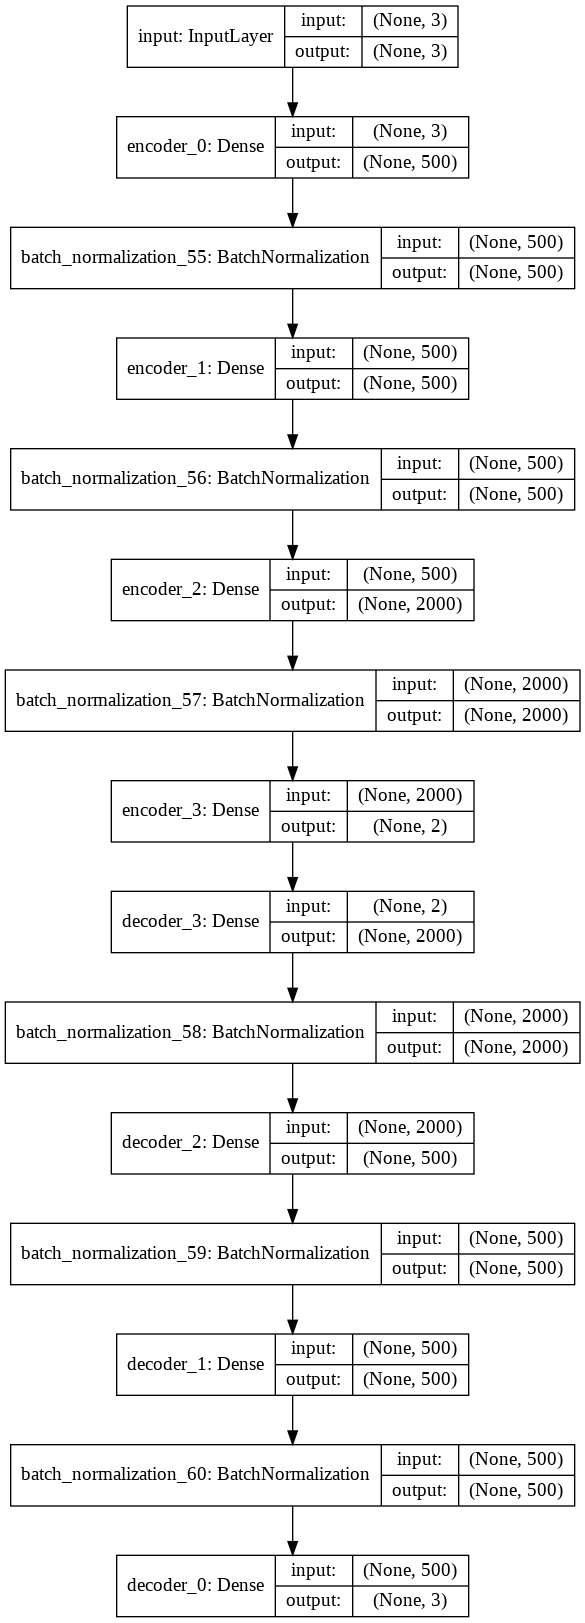

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [23]:
time_means_start = time.time()
y_pred_train_list = []
y_pred_train_list_means = []
accuracy_list = []
accuracy_means_list = []
accuracy_ae_means_list=[]
accuracy_ae_list = []
tsne_list = []
gmm_centres_list = []
gmm_vars_list = []
kmeans_centres_list = []
accuracy_dec_list = []
label_list = []
# dbs = [100, 50, 30, 20, 10] + [i for i in range(9, -1, -1)]
sensitivities = [100, 20, 10] + [5/i for i in range(1, 6, 1)]
for sensitivity in sensitivities:
  if os.path.exists(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy')):
    X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy'))
    labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/sensitivity:.2f}.npy'))
    labels = torch.Tensor(labels)
    X =  torch.Tensor(X)
  else:
    a = creater(sparsity = 1,std=1/sensitivity)
    X = a[0]
    labels = a[1]
    labels = torch.Tensor(labels)
    X =  torch.Tensor(X)
    np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy'), X)
    np.save(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/sensitivity:.2f}.npy'), labels)
  X = normalize(X.numpy(), axis = 0)

  #===========================#
  autoencoder, encoder = Autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_std_{1/sensitivity:.2f}.h5"))
  encoding = encoder.predict(X)
  kmmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  y_pred_ae_means = kmmeans.labels_
  accs_ae_means = metrics.acc(labels.numpy().reshape(10002,), y_pred_ae_means.reshape(10002,))
  print("Accuracy",sensitivity, accs_ae_means)
  accuracy_ae_means_list.append(accs_ae_means)
  np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_std_{1/sensitivity:.2f}.npy'), encoding)
  del kmmeans, accs_ae_means
  #============#
  clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
  k_means = KMeans(n_clusters=2, n_init=20)
  y_pred_ae = k_means.fit_predict(encoding) 
  y_pred_last = np.copy(y_pred_ae)
  model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  # ===================#
  loss = 0
  index = 0
  maxiter = 8000
  update_interval = 140
  index_array = np.arange(X.shape[0])
  tol = 0.001 
  acc = 0
  #=====================#
  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(X, verbose=0)
          p = target_distribution(q) 
          y_pred_ae = q.argmax(1)
          print(y_pred_ae.shape)
          print(labels.numpy().shape)
          if labels.numpy() is not None:
              acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
              nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
              ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
              loss = np.round(loss, 5)
              print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
          delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
          y_pred_last = np.copy(y_pred_ae)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
      loss = model.train_on_batch(x=X[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  accuracy_dec_list.append(acc)
  model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_std_{1/sensitivity:.2f}.h5'))
  encoded_dec = encoder.predict(X)
  np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_std_{1/sensitivity:.2f}.npy'), encoded_dec)
  del encoding, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

  #=========================#
  gmmodel = mixture.GaussianMixture(n_components = 2, random_state = 42, covariance_type= 'full')
  gmmodel.fit(X)  
  gmm_centres_list.append(gmmodel.means_)
  gmm_vars_list.append( gmmodel.covariances_)

  y_pred_train = gmmodel.predict(X)
  print(f'Gaussian Mixtures Models Done for std = {1/sensitivity:.2f}. Time elapsed = {time.time()-time_means_start:.2f}s')
  accuracy = metrics.acc(labels.numpy(), y_pred_train)
  print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')
  #===========================#

  #===========================#
  kmodel = KMeans(n_clusters = 2, random_state = 42)
  kmeans = kmodel.fit(X)
  kmeans_centres_list.append(kmeans.cluster_centers_)
  print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  y_pred_train_means = kmeans.labels_
  accuracy_means = metrics.acc(labels.numpy(), y_pred_train_means)
  print(f'KMeans Accuracy = {accuracy_means*100:.2f}%')
  #===========================#
  
  #===========================#
  # print(f'TSNE Started. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne =  TSNE(n_components=2, random_state=42).fit_transform(X)
  # np.save(os.path.join(synthetic_path, f'tsne_sparsity_1_sensitivity_{sensitivity}'), tsne)
  # print(f'TSNE Completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne_list.append(tsne)
  # del tsne
  #===========================#

  #===========================#
  y_pred_train_list_means.append(y_pred_train_means)
  accuracy_means_list.append(accuracy_means)
  accuracy_list.append(accuracy)
  y_pred_train_list.append(y_pred_train)
  label_list.append(labels)
  
  np.save(os.path.join(synthetic_path, f'gmm_preds_sparsity_1_std_{1/sensitivity:.2f}'), y_pred_train)
  np.save(os.path.join(synthetic_path, f'kmeans_preds_sparsity_1_std_{1/sensitivity:.2f}'), y_pred_train_means)
  del kmodel
  # del autoencoder
  # del encoder
  del gmmodel
  del X
  del labels
  del y_pred_train
  print(f'Done time elapsed = {time.time()-time_means_start:.2f}s') 









Epoch 1/30





10002/10002 [==============================] - 18s 2ms/step - loss: 0.0877
Epoch 2/30
10002/10002 [==============================] - 1s 64us/step - loss: 5.6698e-04
Epoch 3/30
10002/10002 [==============================] - 1s 64us/step - loss: 2.3092e-04
Epoch 4/30
10002/10002 [==============================] - 1s 61us/step - loss: 1.9173e-04
Epoch 5/30
10002/10002 [==============================] - 1s 66us/step - loss: 0.0012
Epoch 6/30
10002/10002 [==============================] - 1s 60us/step - loss: 4.0809e-04
Epoch 7/30
10002/10002 [==============================] - 1s 60us/step - loss: 1.3115e-04
Epoch 8/30
10002/10002 [==============================] - 1s 66us/step - loss: 1.7979e-04
Epoch 9/30
10002/10002 [==============================] - 1s 60us/step - loss: 0.0025
Epoch 10/30
10002/10002 [==============================] - 1s 60us/step - loss: 0.0078
Epoch 11/30
10002/10002 [==============================] - 1s 66us/step - loss: 8.9049e-04
Epoch 12/30

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


(10002,)
(10002, 1)
Iter 0: acc = 0.66607, nmi = 0.23602, ari = 0.11026  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.66607, nmi = 0.23602, ari = 0.11026  ; loss= 0.00043
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.01. Time elapsed = 46.03s
Gaussian Mixture Model Accuracy = 66.96%
KMeans completed. Time elapsed = 46.12s
KMeans Accuracy = 66.96%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 47.20s
Epoch 1/30
10002/10002 [==============================] - 2s 215us/step - loss: 0.3615
Epoch 2/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0016
Epoch 3/30
10002/10002 [==============================] - 1s 59us/step - loss: 4.2082e-04
Epoch 4/30
10002/10002 [==============================] - 1s 63us/step - loss: 3.1073e-04
Epoch 5/30
10002/10002 [==============================] - 1s 60us/step - loss: 2.1483e-04
Epoch 6/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.5737e-04
Epoch 7/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.8297e-04
Epoch 8/30
10002/10002 [==============================] - 1s 64us/step - loss: 2.2220e-04
Epoch 9/30
10002/10002 [==============================] - 1s 68us/step - loss: 8.9819e-05
Epoch 10/30
10002/10002 [==============================] - 1s 70us/step - loss: 1.2850e-04
Epoch 11/30
10002/10002 [==============================] - 1s 67us/step - loss:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 20 0.6651669666066786
(10002,)
(10002, 1)
Iter 0: acc = 0.66517, nmi = 0.23492, ari = 0.10907  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.66517, nmi = 0.23492, ari = 0.10907  ; loss= 0.00081
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.05. Time elapsed = 77.16s
Gaussian Mixture Model Accuracy = 66.85%
KMeans completed. Time elapsed = 77.24s
KMeans Accuracy = 66.64%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 78.23s
Epoch 1/30
10002/10002 [==============================] - 3s 255us/step - loss: 0.2629
Epoch 2/30
10002/10002 [==============================] - 1s 67us/step - loss: 8.4077e-04
Epoch 3/30
10002/10002 [==============================] - 1s 68us/step - loss: 5.3871e-04
Epoch 4/30
10002/10002 [==============================] - 1s 60us/step - loss: 5.3364e-04
Epoch 5/30
10002/10002 [==============================] - 1s 64us/step - loss: 4.6640e-04
Epoch 6/30
10002/10002 [==============================] - 1s 63us/step - loss: 2.4162e-04
Epoch 7/30
10002/10002 [==============================] - 1s 65us/step - loss: 2.7981e-04
Epoch 8/30
10002/10002 [==============================] - 1s 60us/step - loss: 2.6166e-04
Epoch 9/30
10002/10002 [==============================] - 1s 57us/step - loss: 1.5116e-04
Epoch 10/30
10002/10002 [==============================] - 1s 67us/step - loss: 2.0318e-04
Epoch 11/30
10002/10002 [==============================] - 1s 72us/step - l

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 10 0.9982003599280144
(10002,)
(10002, 1)
Iter 0: acc = 0.99820, nmi = 0.98279, ari = 0.99281  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 0.00533


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0.03506
delta_label  9.998000399920016e-05 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.10. Time elapsed = 112.96s
Gaussian Mixture Model Accuracy = 66.79%
KMeans completed. Time elapsed = 113.05s
KMeans Accuracy = 66.63%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 114.07s
Epoch 1/30
10002/10002 [==============================] - 3s 297us/step - loss: 0.3212
Epoch 2/30
10002/10002 [==============================] - 1s 65us/step - loss: 0.0014
Epoch 3/30
10002/10002 [==============================] - 1s 73us/step - loss: 4.0310e-04
Epoch 4/30
10002/10002 [==============================] - 1s 68us/step - loss: 3.0954e-04
Epoch 5/30
10002/10002 [==============================] - 1s 70us/step - loss: 2.7599e-04
Epoch 6/30
10002/10002 [==============================] - 1s 64us/step - loss: 3.3175e-04
Epoch 7/30
10002/10002 [==============================] - 1s 60us/step - loss: 3.0251e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.5575e-04
Epoch 9/30
10002/10002 [==============================] - 1s 63us/step - loss: 1.9837e-04
Epoch 10/30
10002/10002 [==============================] - 1s 59us/step - loss: 1.5749e-04
Epoch 11/30
10002/10002 [==============================] - 1s 69us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 5.0 0.7945410917816437
(10002,)
(10002, 1)
Iter 0: acc = 0.79454, nmi = 0.38476, ari = 0.34696  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.80824, nmi = 0.42361, ari = 0.37999  ; loss= 0.01725


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.81164, nmi = 0.43331, ari = 0.38842  ; loss= 0.02167


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.81244, nmi = 0.44018, ari = 0.39042  ; loss= 0.01691


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.81464, nmi = 0.44393, ari = 0.39593  ; loss= 0.01744


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.81684, nmi = 0.44772, ari = 0.40149  ; loss= 0.01467


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.81954, nmi = 0.45150, ari = 0.40836  ; loss= 0.01697


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.82094, nmi = 0.45395, ari = 0.41195  ; loss= 0.01209


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.82214, nmi = 0.45441, ari = 0.41503  ; loss= 0.01336


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.82294, nmi = 0.45505, ari = 0.41710  ; loss= 0.00939
delta_label  0.0009998000399920016 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.20. Time elapsed = 162.62s
Gaussian Mixture Model Accuracy = 66.50%
KMeans completed. Time elapsed = 162.69s
KMeans Accuracy = 66.71%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 163.97s
Epoch 1/30
10002/10002 [==============================] - 3s 342us/step - loss: 0.5023
Epoch 2/30
10002/10002 [==============================] - 1s 73us/step - loss: 0.0025
Epoch 3/30
10002/10002 [==============================] - 1s 67us/step - loss: 3.6899e-04
Epoch 4/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.7000e-04
Epoch 5/30
10002/10002 [==============================] - 1s 67us/step - loss: 2.3132e-04
Epoch 6/30
10002/10002 [==============================] - 1s 62us/step - loss: 2.0754e-04
Epoch 7/30
10002/10002 [==============================] - 1s 69us/step - loss: 1.5337e-04
Epoch 8/30
10002/10002 [==============================] - 1s 71us/step - loss: 1.3212e-04
Epoch 9/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.2363e-04
Epoch 10/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.2062e-04
Epoch 11/30
10002/10002 [==============================] - 1s 58us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 2.5 0.5843831233753249
(10002,)
(10002, 1)
Iter 0: acc = 0.58438, nmi = 0.08979, ari = 0.02845  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.58898, nmi = 0.08935, ari = 0.03163  ; loss= 0.01255


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.59138, nmi = 0.08332, ari = 0.03336  ; loss= 0.02907


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.59168, nmi = 0.07640, ari = 0.03358  ; loss= 0.01892


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.59518, nmi = 0.07299, ari = 0.03619  ; loss= 0.04031


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.59638, nmi = 0.06994, ari = 0.03711  ; loss= 0.01705


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.59628, nmi = 0.06223, ari = 0.03703  ; loss= 0.02656


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.59488, nmi = 0.05721, ari = 0.03595  ; loss= 0.0159


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.59348, nmi = 0.05130, ari = 0.03490  ; loss= 0.02077


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.59118, nmi = 0.04693, ari = 0.03320  ; loss= 0.01778


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.58788, nmi = 0.04076, ari = 0.03083  ; loss= 0.02792


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.58638, nmi = 0.03826, ari = 0.02978  ; loss= 0.01935


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.58398, nmi = 0.03468, ari = 0.02815  ; loss= 0.03266


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.58118, nmi = 0.03149, ari = 0.02630  ; loss= 0.01868


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.57668, nmi = 0.02670, ari = 0.02345  ; loss= 0.0249


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.57528, nmi = 0.02497, ari = 0.02260  ; loss= 0.01701


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.57049, nmi = 0.02086, ari = 0.01980  ; loss= 0.0217


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.56759, nmi = 0.01873, ari = 0.01820  ; loss= 0.01736


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.56289, nmi = 0.01563, ari = 0.01574  ; loss= 0.031


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.56019, nmi = 0.01398, ari = 0.01441  ; loss= 0.02009


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.55249, nmi = 0.01024, ari = 0.01094  ; loss= 0.04


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.54819, nmi = 0.00839, ari = 0.00921  ; loss= 0.02424


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.54529, nmi = 0.00728, ari = 0.00812  ; loss= 0.05012


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.53469, nmi = 0.00412, ari = 0.00473  ; loss= 0.02417


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.53129, nmi = 0.00332, ari = 0.00383  ; loss= 0.06316


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.52020, nmi = 0.00133, ari = 0.00154  ; loss= 0.02213


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.51940, nmi = 0.00122, ari = 0.00141  ; loss= 0.07899


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.50500, nmi = 0.00008, ari = 0.00001  ; loss= 0.02075


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.50210, nmi = 0.00001, ari = -0.00008  ; loss= 0.08762


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.50990, nmi = 0.00030, ari = 0.00030  ; loss= 0.02405


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.51180, nmi = 0.00042, ari = 0.00046  ; loss= 0.08331


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.51960, nmi = 0.00115, ari = 0.00144  ; loss= 0.03033


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.52120, nmi = 0.00135, ari = 0.00170  ; loss= 0.08024


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.52939, nmi = 0.00257, ari = 0.00336  ; loss= 0.03066


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.53149, nmi = 0.00293, ari = 0.00387  ; loss= 0.08309


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.53919, nmi = 0.00451, ari = 0.00605  ; loss= 0.03094


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.54079, nmi = 0.00488, ari = 0.00656  ; loss= 0.0884


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.55019, nmi = 0.00734, ari = 0.00998  ; loss= 0.03254


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.55239, nmi = 0.00798, ari = 0.01088  ; loss= 0.09099


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.55959, nmi = 0.01031, ari = 0.01410  ; loss= 0.03554


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.56219, nmi = 0.01121, ari = 0.01537  ; loss= 0.09131


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.56669, nmi = 0.01289, ari = 0.01769  ; loss= 0.03631


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.56949, nmi = 0.01399, ari = 0.01922  ; loss= 0.08848


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.57399, nmi = 0.01586, ari = 0.02180  ; loss= 0.03443


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.57708, nmi = 0.01721, ari = 0.02367  ; loss= 0.08549


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.58118, nmi = 0.01910, ari = 0.02627  ; loss= 0.033


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.58338, nmi = 0.02017, ari = 0.02771  ; loss= 0.08118


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.58858, nmi = 0.02279, ari = 0.03129  ; loss= 0.03172


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.58988, nmi = 0.02350, ari = 0.03222  ; loss= 0.0732


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.59448, nmi = 0.02601, ari = 0.03561  ; loss= 0.0312


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.59398, nmi = 0.02575, ari = 0.03523  ; loss= 0.06243


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.60038, nmi = 0.02949, ari = 0.04021  ; loss= 0.02845


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.59938, nmi = 0.02892, ari = 0.03941  ; loss= 0.05475


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.60668, nmi = 0.03351, ari = 0.04543  ; loss= 0.0285


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.60578, nmi = 0.03297, ari = 0.04466  ; loss= 0.04951


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.61398, nmi = 0.03866, ari = 0.05187  ; loss= 0.02898


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.61438, nmi = 0.03899, ari = 0.05224  ; loss= 0.04375


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.62158, nmi = 0.04454, ari = 0.05903  ; loss= 0.02762


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.40. Time elapsed = 288.08s
Gaussian Mixture Model Accuracy = 50.94%
KMeans completed. Time elapsed = 288.24s
KMeans Accuracy = 53.04%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 289.17s
Epoch 1/30
10002/10002 [==============================] - 4s 385us/step - loss: 0.4519
Epoch 2/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0021
Epoch 3/30
10002/10002 [==============================] - 1s 64us/step - loss: 4.4907e-04
Epoch 4/30
10002/10002 [==============================] - 1s 64us/step - loss: 2.9604e-04
Epoch 5/30
10002/10002 [==============================] - 1s 61us/step - loss: 2.3825e-04
Epoch 6/30
10002/10002 [==============================] - 1s 64us/step - loss: 1.9054e-04
Epoch 7/30
10002/10002 [==============================] - 1s 64us/step - loss: 2.2918e-04
Epoch 8/30
10002/10002 [==============================] - 1s 61us/step - loss: 2.3339e-04
Epoch 9/30
10002/10002 [==============================] - 1s 64us/step - loss: 1.4408e-04
Epoch 10/30
10002/10002 [==============================] - 1s 62us/step - loss: 1.4465e-04
Epoch 11/30
10002/10002 [==============================] - 1s 67us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.6666666666666667 0.5373925214957008
(10002,)
(10002, 1)
Iter 0: acc = 0.53689, nmi = 0.00708, ari = 0.00538  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.53119, nmi = 0.00452, ari = 0.00382  ; loss= 0.0138


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.52679, nmi = 0.00306, ari = 0.00280  ; loss= 0.10234


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.52350, nmi = 0.00227, ari = 0.00213  ; loss= 0.01373


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.52280, nmi = 0.00210, ari = 0.00200  ; loss= 0.07286


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.52030, nmi = 0.00163, ari = 0.00157  ; loss= 0.01352


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.52180, nmi = 0.00191, ari = 0.00182  ; loss= 0.05727


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.51810, nmi = 0.00127, ari = 0.00123  ; loss= 0.01517


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.52060, nmi = 0.00167, ari = 0.00162  ; loss= 0.04752


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.51680, nmi = 0.00108, ari = 0.00105  ; loss= 0.0157


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.51940, nmi = 0.00145, ari = 0.00142  ; loss= 0.04481


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.51580, nmi = 0.00094, ari = 0.00092  ; loss= 0.01529


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.51730, nmi = 0.00113, ari = 0.00111  ; loss= 0.04548


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.51390, nmi = 0.00072, ari = 0.00069  ; loss= 0.01402


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.51560, nmi = 0.00091, ari = 0.00089  ; loss= 0.04526


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.51320, nmi = 0.00064, ari = 0.00061  ; loss= 0.01235


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.51600, nmi = 0.00095, ari = 0.00094  ; loss= 0.04125


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.51400, nmi = 0.00072, ari = 0.00070  ; loss= 0.01084


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.51770, nmi = 0.00117, ari = 0.00117  ; loss= 0.03663


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.51550, nmi = 0.00089, ari = 0.00088  ; loss= 0.0104


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.51840, nmi = 0.00127, ari = 0.00127  ; loss= 0.03242


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.51590, nmi = 0.00093, ari = 0.00093  ; loss= 0.01023


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.51790, nmi = 0.00120, ari = 0.00120  ; loss= 0.02589


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.51570, nmi = 0.00091, ari = 0.00090  ; loss= 0.01036


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.51760, nmi = 0.00115, ari = 0.00116  ; loss= 0.01809


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.51620, nmi = 0.00096, ari = 0.00097  ; loss= 0.01074


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.51760, nmi = 0.00115, ari = 0.00116  ; loss= 0.01181


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.51610, nmi = 0.00095, ari = 0.00095  ; loss= 0.01081


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.51730, nmi = 0.00110, ari = 0.00111  ; loss= 0.00857


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.51550, nmi = 0.00087, ari = 0.00088  ; loss= 0.01067


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.51660, nmi = 0.00101, ari = 0.00102  ; loss= 0.00747


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.51530, nmi = 0.00084, ari = 0.00085  ; loss= 0.01032


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.51640, nmi = 0.00098, ari = 0.00099  ; loss= 0.0068


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.51520, nmi = 0.00083, ari = 0.00084  ; loss= 0.00966


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.51670, nmi = 0.00102, ari = 0.00103  ; loss= 0.00636


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.51580, nmi = 0.00089, ari = 0.00091  ; loss= 0.00907


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.51770, nmi = 0.00114, ari = 0.00117  ; loss= 0.00619


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.51620, nmi = 0.00093, ari = 0.00096  ; loss= 0.00909


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.51780, nmi = 0.00115, ari = 0.00118  ; loss= 0.00602


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.51680, nmi = 0.00100, ari = 0.00104  ; loss= 0.00902


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.51830, nmi = 0.00121, ari = 0.00125  ; loss= 0.00566


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.51640, nmi = 0.00095, ari = 0.00099  ; loss= 0.00898


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.51830, nmi = 0.00121, ari = 0.00125  ; loss= 0.00571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.51640, nmi = 0.00095, ari = 0.00099  ; loss= 0.009


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.51830, nmi = 0.00121, ari = 0.00125  ; loss= 0.00556


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.51570, nmi = 0.00087, ari = 0.00090  ; loss= 0.00897


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.51770, nmi = 0.00113, ari = 0.00117  ; loss= 0.00538


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.51500, nmi = 0.00079, ari = 0.00081  ; loss= 0.00905


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.51760, nmi = 0.00111, ari = 0.00115  ; loss= 0.00526


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.51510, nmi = 0.00080, ari = 0.00082  ; loss= 0.00904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.51740, nmi = 0.00109, ari = 0.00113  ; loss= 0.00497


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.51490, nmi = 0.00078, ari = 0.00080  ; loss= 0.00933


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.51720, nmi = 0.00106, ari = 0.00110  ; loss= 0.00469


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.51480, nmi = 0.00076, ari = 0.00079  ; loss= 0.00952


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.51730, nmi = 0.00107, ari = 0.00111  ; loss= 0.00444


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.51460, nmi = 0.00074, ari = 0.00077  ; loss= 0.00942


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.51740, nmi = 0.00108, ari = 0.00113  ; loss= 0.00427


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.51440, nmi = 0.00072, ari = 0.00074  ; loss= 0.0095


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.60. Time elapsed = 417.33s
Gaussian Mixture Model Accuracy = 51.68%
KMeans completed. Time elapsed = 417.46s
KMeans Accuracy = 50.59%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 418.33s
Epoch 1/30
10002/10002 [==============================] - 4s 415us/step - loss: 0.4375
Epoch 2/30
10002/10002 [==============================] - 1s 56us/step - loss: 0.0025
Epoch 3/30
10002/10002 [==============================] - 1s 67us/step - loss: 7.9893e-04
Epoch 4/30
10002/10002 [==============================] - 1s 65us/step - loss: 4.4967e-04
Epoch 5/30
10002/10002 [==============================] - 1s 73us/step - loss: 4.1957e-04
Epoch 6/30
10002/10002 [==============================] - 1s 67us/step - loss: 3.3818e-04
Epoch 7/30
10002/10002 [==============================] - 1s 63us/step - loss: 4.0605e-04
Epoch 8/30
10002/10002 [==============================] - 1s 62us/step - loss: 3.5100e-04
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 3.8843e-04
Epoch 10/30
10002/10002 [==============================] - 1s 70us/step - loss: 2.7780e-04
Epoch 11/30
10002/10002 [==============================] - 1s 63us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.25 0.51749650069986
(10002,)
(10002, 1)
Iter 0: acc = 0.51750, nmi = 0.00120, ari = 0.00114  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.51920, nmi = 0.00131, ari = 0.00139  ; loss= 0.02646


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.52000, nmi = 0.00134, ari = 0.00151  ; loss= 0.202


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.51830, nmi = 0.00108, ari = 0.00125  ; loss= 0.04174


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.51940, nmi = 0.00120, ari = 0.00141  ; loss= 0.20383


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.51760, nmi = 0.00100, ari = 0.00115  ; loss= 0.03432


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51950, nmi = 0.00127, ari = 0.00143  ; loss= 0.22659


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.51790, nmi = 0.00109, ari = 0.00119  ; loss= 0.02222


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.51910, nmi = 0.00127, ari = 0.00137  ; loss= 0.2262


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.51920, nmi = 0.00129, ari = 0.00139  ; loss= 0.01869


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.51890, nmi = 0.00125, ari = 0.00134  ; loss= 0.22235


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.51890, nmi = 0.00123, ari = 0.00134  ; loss= 0.01762


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.51860, nmi = 0.00119, ari = 0.00130  ; loss= 0.2272


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.51940, nmi = 0.00125, ari = 0.00142  ; loss= 0.01615


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.51930, nmi = 0.00124, ari = 0.00140  ; loss= 0.24061
delta_label  0.0006998600279944011 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.80. Time elapsed = 482.34s
Gaussian Mixture Model Accuracy = 50.92%
KMeans completed. Time elapsed = 482.48s
KMeans Accuracy = 50.72%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 483.55s
Epoch 1/30
10002/10002 [==============================] - 5s 470us/step - loss: 0.3741
Epoch 2/30
10002/10002 [==============================] - 1s 61us/step - loss: 0.0019
Epoch 3/30
10002/10002 [==============================] - 1s 71us/step - loss: 4.4626e-04
Epoch 4/30
10002/10002 [==============================] - 1s 68us/step - loss: 3.2220e-04
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 2.7026e-04
Epoch 6/30
10002/10002 [==============================] - 1s 65us/step - loss: 2.3388e-04
Epoch 7/30
10002/10002 [==============================] - 1s 63us/step - loss: 2.0235e-04
Epoch 8/30
10002/10002 [==============================] - 1s 63us/step - loss: 1.5935e-04
Epoch 9/30
10002/10002 [==============================] - 1s 60us/step - loss: 1.5633e-04
Epoch 10/30
10002/10002 [==============================] - 1s 64us/step - loss: 1.4822e-04
Epoch 11/30
10002/10002 [==============================] - 1s 61us/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.0 0.5077984403119377
(10002,)
(10002, 1)
Iter 0: acc = 0.50780, nmi = 0.00022, ari = 0.00016  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50630, nmi = 0.00014, ari = 0.00007  ; loss= 0.036


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50590, nmi = 0.00012, ari = 0.00005  ; loss= 0.10024


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50720, nmi = 0.00018, ari = 0.00012  ; loss= 0.03816


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50580, nmi = 0.00011, ari = 0.00005  ; loss= 0.13151


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50720, nmi = 0.00018, ari = 0.00012  ; loss= 0.03841


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.50470, nmi = 0.00007, ari = -0.00000  ; loss= 0.12888


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.50520, nmi = 0.00009, ari = 0.00002  ; loss= 0.035


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.50540, nmi = 0.00010, ari = 0.00003  ; loss= 0.13812


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.50550, nmi = 0.00010, ari = 0.00003  ; loss= 0.03141


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.50420, nmi = 0.00006, ari = -0.00002  ; loss= 0.13598


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.50540, nmi = 0.00010, ari = 0.00003  ; loss= 0.02893


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.50410, nmi = 0.00005, ari = -0.00002  ; loss= 0.12941


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.50550, nmi = 0.00010, ari = 0.00003  ; loss= 0.0276


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.50440, nmi = 0.00006, ari = -0.00001  ; loss= 0.12245


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.50540, nmi = 0.00010, ari = 0.00003  ; loss= 0.02711


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.50420, nmi = 0.00006, ari = -0.00002  ; loss= 0.11572


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.50410, nmi = 0.00006, ari = -0.00002  ; loss= 0.02693


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.50410, nmi = 0.00005, ari = -0.00002  ; loss= 0.10904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.50460, nmi = 0.00007, ari = -0.00001  ; loss= 0.02704


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.50460, nmi = 0.00007, ari = -0.00001  ; loss= 0.10283


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.50430, nmi = 0.00006, ari = -0.00002  ; loss= 0.02717


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.50480, nmi = 0.00007, ari = -0.00000  ; loss= 0.09747


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.50490, nmi = 0.00008, ari = 0.00001  ; loss= 0.02743


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.50460, nmi = 0.00007, ari = -0.00001  ; loss= 0.09249


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.50520, nmi = 0.00009, ari = 0.00002  ; loss= 0.02759


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.50390, nmi = 0.00005, ari = -0.00003  ; loss= 0.08846


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.50530, nmi = 0.00009, ari = 0.00002  ; loss= 0.028


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.50210, nmi = 0.00001, ari = -0.00008  ; loss= 0.08604


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.50560, nmi = 0.00010, ari = 0.00003  ; loss= 0.02839


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.50340, nmi = 0.00004, ari = -0.00005  ; loss= 0.08675


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.50530, nmi = 0.00009, ari = 0.00002  ; loss= 0.02884


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.50380, nmi = 0.00005, ari = -0.00004  ; loss= 0.0911


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.50560, nmi = 0.00010, ari = 0.00003  ; loss= 0.02934


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.50380, nmi = 0.00005, ari = -0.00004  ; loss= 0.10036


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.50450, nmi = 0.00006, ari = -0.00001  ; loss= 0.02975


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.50400, nmi = 0.00005, ari = -0.00003  ; loss= 0.10618


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.50480, nmi = 0.00007, ari = -0.00000  ; loss= 0.0305


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.50460, nmi = 0.00007, ari = -0.00001  ; loss= 0.10624


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.50580, nmi = 0.00011, ari = 0.00004  ; loss= 0.03134


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.50590, nmi = 0.00011, ari = 0.00004  ; loss= 0.09661


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.50610, nmi = 0.00012, ari = 0.00005  ; loss= 0.03211


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.50620, nmi = 0.00012, ari = 0.00006  ; loss= 0.08299


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.50630, nmi = 0.00012, ari = 0.00006  ; loss= 0.03256


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.50520, nmi = 0.00008, ari = 0.00001  ; loss= 0.07058


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.50640, nmi = 0.00013, ari = 0.00007  ; loss= 0.03313


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.50540, nmi = 0.00009, ari = 0.00002  ; loss= 0.06102


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.50710, nmi = 0.00016, ari = 0.00011  ; loss= 0.03369


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.50560, nmi = 0.00010, ari = 0.00003  ; loss= 0.05372


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.50710, nmi = 0.00016, ari = 0.00011  ; loss= 0.03407


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.50540, nmi = 0.00009, ari = 0.00002  ; loss= 0.04837


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.50660, nmi = 0.00013, ari = 0.00008  ; loss= 0.03472


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.50450, nmi = 0.00006, ari = -0.00002  ; loss= 0.04316


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.50530, nmi = 0.00009, ari = 0.00002  ; loss= 0.03539


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.50460, nmi = 0.00006, ari = -0.00001  ; loss= 0.03944


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.50540, nmi = 0.00009, ari = 0.00002  ; loss= 0.03563


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.50440, nmi = 0.00006, ari = -0.00002  ; loss= 0.03622


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.50500, nmi = 0.00008, ari = 0.00000  ; loss= 0.03597


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 1.00. Time elapsed = 619.16s
Gaussian Mixture Model Accuracy = 50.27%
KMeans completed. Time elapsed = 619.28s
KMeans Accuracy = 50.72%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Done time elapsed = 620.20s


### Visualization and Evaluation

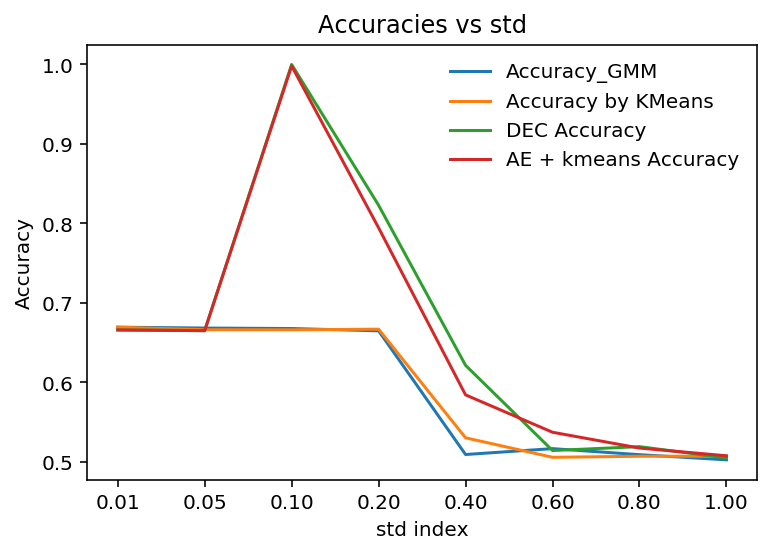

In [24]:
tol = 0.001
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sensitivities = [100, 20, 10] + [5/i for i in range(1, 6, 1)]
names = list(map(lambda x : f'{1/x:.2f}', sensitivities))
plt.plot(names, accuracy_list, label='Accuracy_GMM')
plt.plot(accuracy_means_list, label = 'Accuracy by KMeans')
plt.xlabel('std index')
plt.ylabel("Accuracy")
plt.plot(accuracy_dec_list, label='DEC Accuracy')
plt.plot(accuracy_ae_means_list, label = 'AE + kmeans Accuracy')
# plt.plot(accuracy_ae_list, label = 'AE Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs std')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_stds_tol_{tol}_update_interval_{update_interval}.png'))

In [51]:
eps = 1e-9
for i in range(len(gmm_vars_list)):
  a = np.linalg.norm(gmm_vars_list[i][0])/(np.linalg.norm(gmm_vars_list[i][1])+eps)
  b = 1/a
  if(b>a):
    a = b
  print(i,f'{a:.2f}')

0 51.33
1 31.86
2 14.80
3 5.45
4 1.58
5 1.68
6 1.61
7 1.78


In [0]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


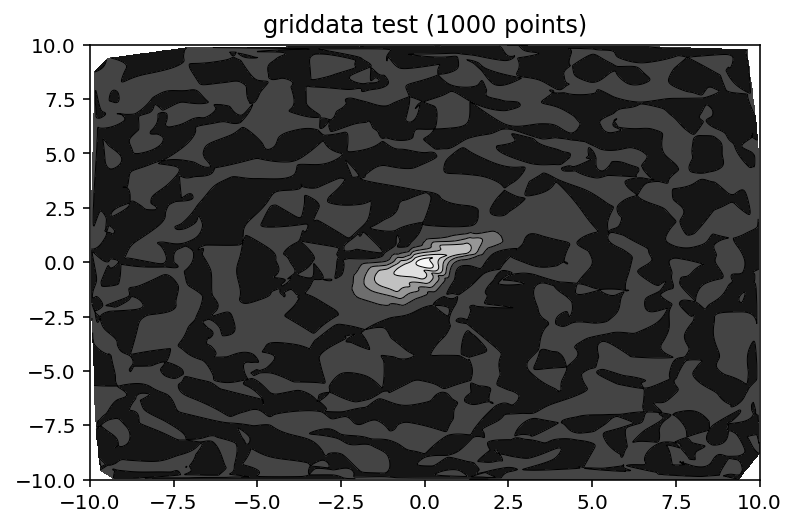

In [0]:
i = 4
j = 5
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'))
pca = PCA(n_components=2)
pcax = pca.fit_transform(X)
gcentres_1 = pca.transform(gmm_centres_list[i][0].reshape(1,39)).reshape(2,)
gcentres_2 = pca.transform(gmm_centres_list[i][1].reshape(1,39)).reshape(2,)
gvars_1 = pca.transform(gmm_vars_list[i][0])
gvars_11 = pca.transform(gvars_1.T)
gvars_1_actual = gvars_11.T
gvars_2 = pca.transform(gmm_vars_list[i][1])
gvars_22 = pca.transform(gvars_2.T)
gvars_2_actual = gvars_22.T
def gauss(x,y,Sigma,mu):
    X1=np.vstack((x,y)).T
    mat_multi=np.dot((X1-mu[None,...]).dot(np.linalg.inv(Sigma)/10000),(X1-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))

def plot_countour(x,y,z):
    # define grid.
    
    xi = np.linspace(-10.1,10.1,1000)
    yi = np.linspace(-10.1,10.1,1000)
    ## grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    # contour the gridded data, plotting dots at the randomly spaced data points.
    CS = plt.contour(xi,yi,zi,6,linewidths=0.5,colors='k')
    #CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    CS = plt.contourf(xi,yi,zi,6,cmap=cm.Greys_r)
    #plt.colorbar() # draw colorbar
    # plot data points.
    #plt.scatter(x,y,marker='o',c='b',s=5)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.title('griddata test (%d points)' % npts)


# make up some randomly distributed data
seed(1234)
npts = 1000
x = uniform(-10,10,npts)
y = uniform(-10,10,npts)
z = gauss(x,y,Sigma=gvars_2_actual,mu=gcentres_2)
plot_countour(x,y,z)
plt.savefig(os.path.join(synthetic_path, f'gmm_contour_sparsity_1_std_{1/j:.2f}.png'))

In [0]:
[np.linalg.norm(pca.components_[i][:]) for i in range(pca.components_.shape[0]) ]

[1.0000002, 1.0]

In [0]:
np.linalg.norm(gmm_vars_list[i][0])

0.0002950515248753787

In [0]:
norms = [np.linalg.norm((gmm_vars_list[i][0])) for i in range(len(gmm_vars_list))]
print((min(norms)), max(norms), np.mean(np.asarray(norms)))

2.2504060021995058e-05 0.0011351027492632823 0.0004034556178354216


In [0]:
x11 = np.asarray([0,1]).reshape(1,2)
x12 = np.asarray([1,0]).reshape(1,2)
x13 = np.asarray([1,1]).reshape(1,2)
x14 = np.asarray([0,0]).reshape(1,2)
m1 = np.dot( ((x11 - gcentres_1).dot( np.linalg.inv(gvars_1_actual/100) )), (x11-gcentres_1).T  ) 

In [0]:
np.exp(-1*m1.item())

4.127952081033937e-122

In [0]:
import numpy as np

def np_bivariate_normal_pdf(domain, meanx, meany, variance):
  X = np.arange(-domain+meanx, domain+meanx, variance)
  Y = np.arange(-domain+meany, domain+meany, variance)
  X, Y = np.meshgrid(X, Y)
  R = np.sqrt(X**2 + Y**2)
  Z = ((1. / np.sqrt(2 * np.pi)) * np.exp(-.5*R**2))
  return X+meanx, Y+meany, Z

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plt_plot_bivariate_normal_pdf(x, y, z, name):
  fig = plt.figure(figsize=(12, 6))
  ax = fig.gca(projection='3d')
  ax.plot_surface(x, y, z, 
                  cmap=cm.coolwarm,
                  linewidth=0, 
                  antialiased=True)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');
  plt.show()

In [0]:
plt_plot_bivariate_normal_pdf(*np_bivariate_normal_pdf(6, gcentres_1[0].item(), gcentres_1[1].item(), gvars_1_actual))

In [0]:
gcentres_1

array([-0.00102067,  0.00760056])

In [0]:
gcentres.shape

(2,)

In [0]:
mu=np.asarray([0.,0.])

In [0]:
mu.shape

(2,)

In [0]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm)
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

In [0]:
time_start = time.time()
i = 0
j = 100
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'))
pca = PCA(n_components=2)
pcax = pca.fit(X)
print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')
gcentres = pca.transform(gmm_centres_list[i])
gvars = pca.transform(gmm_vars_list[i])
def gauss(x,y,Sigma,mu):
    X=np.vstack((x,y)).T
    mat_multi=np.dot((X-mu[None,...]).dot(np.linalg.inv(Sigma)),(X-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))

def plot_countour(x,y,z):
    # define grid.
    xi = np.linspace(-2.1,2.1,100)
    yi = np.linspace(-2.1,2.1,100)
    ## grid the data.
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    # contour the gridded data, plotting dots at the randomly spaced data points.
    CS = plt.contour(xi,yi,zi,6,linewidths=0.5,colors='k')
    #CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    CS = plt.contourf(xi,yi,zi,6,cmap=cm.Greys_r, )
    #plt.colorbar() # draw colorbar
    # plot data points.
    #plt.scatter(x,y,marker='o',c='b',s=5)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.title('griddata test (%d points)' % npts)
    plt.show()


# make up some randomly distributed data
seed(1234)
npts = 1000
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
z = gauss(x,y,Sigma=np.asarray([[1.,0.],[0.,1.]]),mu=np.asarray([0.,0.]))
plot_countour(x,y,z)
plt.savefig(os.path.join(synthetic_path, f'Gaussian_Contourt'))
for i in tqdm(range(len(pca))):
  plt.scatter(pcax[i][0], pcax[i][1], c=colors[int(y[i].item())])
plt.title(f'PCA Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
plt.savefig(os.path.join(synthetic_path, f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))  
plt.clf()
print(f'Visualized PCA Grounds. Time elapsed = {time.time()- time_start:.2f}s')  
del pca

In [0]:
time_start = time.time()
js = [100, 10, 5, 5/3, 5/4,1]
for j in js:
  if os.path.exists(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy')):
    X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'))
    y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'))
    # labels = torch.Tensor(labels)
    # X =  torch.Tensor(X)
  else:
    a = creater(sparsity = 1,std=1/j)
    X = a[0].numpy()
    y = a[1].numpy()
    np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'),X)
    np.save(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'), y)
  
  tsne = TSNE(n_components=2).fit_transform(X)
  print(f'TSNE done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(tsne))):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y[i].item())])
  plt.title(f'TSNE Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized TSNE Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  del tsne

  pca_model = PCA(n_components=2)
  pca = pca_model.fit_transform(X)
  print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')
  filename = os.path.join(synthetic_path, f'pca_wo_norm_model_sparsity_1_std_{1/j:.2f}.sav')
  pickle.dump(pca_model, open(filename, 'wb'))
  del pca_model

  for i in tqdm(range(len(pca))):
    plt.scatter(pca[i][0], pca[i][1], c=colors[int(y[i].item())])
  plt.title(f'PCA Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))  
  plt.clf()
  print(f'Visualized PCA Grounds. Time elapsed = {time.time()- time_start:.2f}s')  
  del pca

  Lda = LinearDiscriminantAnalysis(n_components=2)
  lda = Lda.fit_transform(X, y.reshape(len(y),))
  plt.hist(lda)
  plt.title(f'LDA Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  del lda, Lda
  print(f'LDA done. Time elapsed = {time.time()- time_start:.2f}s')

  if(j == 100):
      to_conc = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
      po_conc = cv2.imread(os.path.join(synthetic_path, f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
      lo_conc = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  else:
    ton = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    po = cv2.imread(os.path.join(synthetic_path,f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    lo = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    to_conc = cv2.hconcat([to_conc, ton])
    po_conc = cv2.hconcat([po_conc, po])
    lo_conc = cv2.hconcat([lo_conc, lo])
    del ton,po,lo  

  X = normalize(X, axis = 0)
  print('Normalized.')

  tsne = TSNE(n_components=2).fit_transform(X)
  print(f'TSNE done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(tsne))):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y[i].item())])
  plt.title(f'TSNE Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized TSNE Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  del tsne

  pca_model = PCA(n_components=2)
  pca = pca_model.fit_transform(X)
  print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')
  filename = os.path.join(synthetic_path, f'pca_w_norm_model_sparsity_1_std_{1/j:.2f}.sav')
  pickle.dump(pca_model, open(filename, 'wb'))
  del pca_model
  
  for i in tqdm(range(len(pca))):
    plt.scatter(pca[i][0], pca[i][1], c=colors[int(y[i].item())])
  plt.title(f'PCA Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized PCA Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  
  del pca

  Lda = LinearDiscriminantAnalysis(n_components=2)
  lda = Lda.fit_transform(X, y.reshape(len(y),))
  plt.hist(lda)
  plt.title(f'LDA Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.legend(frameon=False)
  plt.savefig(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  del lda, Lda
  print(f'LDA done. Time elapsed = {time.time()- time_start:.2f}s')

  if(j == 100):
      t_conc = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
      p_conc = cv2.imread(os.path.join(synthetic_path, f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
      l_conc = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  else:
    t = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    p = cv2.imread(os.path.join(synthetic_path,f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    l = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    t_conc = cv2.hconcat([t_conc, t])
    p_conc = cv2.hconcat([p_conc, p])
    l_conc = cv2.hconcat([l_conc, l])
    del t,p,l
  del X, y
  print(f'Done std {1/j:.2f}. Time Elapsed = {time.time()- time_start:.2f}s')

cv2.imwrite(os.path.join(synthetic_path, 'tsne_visualization_wo_normalization_for_all_std.png'), to_conc)
cv2.imwrite(os.path.join(synthetic_path, 'tsne_visualization_w_normalization_for_all_std.png'), t_conc)
cv2.imwrite(os.path.join(synthetic_path, 'pca_visualization_wo_normalization_for_all_std.png'), po_conc)
cv2.imwrite(os.path.join(synthetic_path, 'pca_visualization_w_normalization_for_all_std.png'), p_conc)
cv2.imwrite(os.path.join(synthetic_path, 'lda_visualization_wo_normalization_for_all_std.png'), lo_conc)
cv2.imwrite(os.path.join(synthetic_path, 'lda_visualization_w_normalization_for_all_std.png'), l_conc)

  0%|          | 26/10002 [00:00<00:39, 255.18it/s]

TSNE done. Time elapsed = 100.34s


  0%|          | 26/10002 [00:00<00:38, 256.18it/s]

Visualized TSNE Grounds. Time elapsed = 182.32s
PCA done. Time elapsed = 182.35s


100%|██████████| 10002/10002 [01:17<00:00, 129.23it/s]


Visualized PCA Grounds. Time elapsed = 265.77s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 266.10s
Normalized.


  0%|          | 28/10002 [00:00<00:35, 277.50it/s]

TSNE done. Time elapsed = 353.56s


  0%|          | 26/10002 [00:00<00:39, 255.14it/s]

Visualized TSNE Grounds. Time elapsed = 435.47s
PCA done. Time elapsed = 435.49s


100%|██████████| 10002/10002 [01:17<00:00, 129.14it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 519.15s
LDA done. Time elapsed = 519.41s
Done std 0.01. Time Elapsed = 519.42s


  0%|          | 29/10002 [00:00<00:35, 283.45it/s]

TSNE done. Time elapsed = 614.59s


  0%|          | 25/10002 [00:00<00:40, 249.30it/s]

Visualized TSNE Grounds. Time elapsed = 698.02s
PCA done. Time elapsed = 698.05s


100%|██████████| 10002/10002 [01:18<00:00, 128.01it/s]


Visualized PCA Grounds. Time elapsed = 782.54s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 782.80s
Normalized.


  0%|          | 27/10002 [00:00<00:37, 265.45it/s]

TSNE done. Time elapsed = 880.54s


  0%|          | 28/10002 [00:00<00:36, 275.86it/s]

Visualized TSNE Grounds. Time elapsed = 962.69s
PCA done. Time elapsed = 962.71s


100%|██████████| 10002/10002 [01:14<00:00, 74.76it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 1043.04s
LDA done. Time elapsed = 1043.29s
Done std 0.10. Time Elapsed = 1043.31s


  0%|          | 24/10002 [00:00<00:43, 230.51it/s]

TSNE done. Time elapsed = 1165.48s


  0%|          | 27/10002 [00:00<00:37, 264.22it/s]

Visualized TSNE Grounds. Time elapsed = 1248.50s
PCA done. Time elapsed = 1248.52s


100%|██████████| 10002/10002 [01:16<00:00, 130.69it/s]


Visualized PCA Grounds. Time elapsed = 1330.99s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 1331.25s
Normalized.


  0%|          | 24/10002 [00:00<00:41, 237.86it/s]

TSNE done. Time elapsed = 1440.81s


  0%|          | 27/10002 [00:00<00:37, 267.81it/s]

Visualized TSNE Grounds. Time elapsed = 1521.37s
PCA done. Time elapsed = 1521.39s


100%|██████████| 10002/10002 [01:16<00:00, 130.75it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 1603.95s
LDA done. Time elapsed = 1604.21s
Done std 0.20. Time Elapsed = 1604.23s


  0%|          | 27/10002 [00:00<00:37, 268.46it/s]

TSNE done. Time elapsed = 1814.26s


  0%|          | 24/10002 [00:00<00:41, 239.14it/s]

Visualized TSNE Grounds. Time elapsed = 1897.29s
PCA done. Time elapsed = 1897.31s


100%|██████████| 10002/10002 [01:17<00:00, 128.26it/s]


Visualized PCA Grounds. Time elapsed = 1981.73s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 1981.98s
Normalized.


  0%|          | 24/10002 [00:00<00:41, 238.01it/s]

TSNE done. Time elapsed = 2148.30s


  0%|          | 27/10002 [00:00<00:37, 265.37it/s]

Visualized TSNE Grounds. Time elapsed = 2230.33s
PCA done. Time elapsed = 2230.36s


100%|██████████| 10002/10002 [01:17<00:00, 128.75it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 2314.13s
LDA done. Time elapsed = 2314.39s
Done std 0.60. Time Elapsed = 2314.40s


  0%|          | 29/10002 [00:00<00:35, 281.90it/s]

TSNE done. Time elapsed = 2489.75s


  0%|          | 20/10002 [00:00<00:51, 195.02it/s]

Visualized TSNE Grounds. Time elapsed = 2573.25s
PCA done. Time elapsed = 2573.27s


100%|██████████| 10002/10002 [01:23<00:00, 120.43it/s]


Visualized PCA Grounds. Time elapsed = 2665.61s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 2665.90s
Normalized.


  0%|          | 24/10002 [00:00<00:41, 238.49it/s]

TSNE done. Time elapsed = 2827.46s


  0%|          | 22/10002 [00:00<00:45, 219.30it/s]

Visualized TSNE Grounds. Time elapsed = 2918.00s
PCA done. Time elapsed = 2918.02s


100%|██████████| 10002/10002 [01:26<00:00, 115.89it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 3010.97s
LDA done. Time elapsed = 3011.27s
Done std 0.80. Time Elapsed = 3011.29s


  0%|          | 22/10002 [00:00<00:45, 218.62it/s]

TSNE done. Time elapsed = 3135.29s


  0%|          | 22/10002 [00:00<00:46, 214.76it/s]

Visualized TSNE Grounds. Time elapsed = 3226.60s
PCA done. Time elapsed = 3226.63s


100%|██████████| 10002/10002 [01:25<00:00, 117.56it/s]


Visualized PCA Grounds. Time elapsed = 3318.43s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 3319.37s
Normalized.


  0%|          | 24/10002 [00:00<00:42, 232.35it/s]

TSNE done. Time elapsed = 3509.42s


  0%|          | 22/10002 [00:00<00:45, 217.41it/s]

Visualized TSNE Grounds. Time elapsed = 3600.40s
PCA done. Time elapsed = 3600.43s


100%|██████████| 10002/10002 [01:24<00:00, 77.16it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 3691.59s
LDA done. Time elapsed = 3691.88s
Done std 1.00. Time Elapsed = 3691.89s


True

<Figure size 432x288 with 0 Axes>

In [33]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Fixing random state for reproducibility
np.random.seed(19680801)
markers = ['o', '^']
time_start = time.time()
js = [100, 10, 5, 5/3, 5/4,1]
list_index = [0,2,3,5,6,7]
# js = [5/2]

for k,j in enumerate(js):
  if os.path.exists(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy')):
    X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'))
    y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'))
    
  else:
    a = creater(sparsity = 1,std=1/j)
    X = a[0]
    y = a[1]
    np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'),X)
    np.save(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'), y)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  n = 100

  for i in tqdm(range(len(X))):
      ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[int(y_pred_train_list[list_index[k]][i].item())])

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title(f'GMM Prediction Vis. std = {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'data_gmm_preds sparsity_1_std_{1/j:.2f}.png'))
  plt.clf()


for j in js:
  if (j == 100):
    data_conc = cv2.imread(os.path.join(synthetic_path, f'data_gmm_preds sparsity_1_std_{1/j:.2f}.png'))
    print('g',data_conc)
  else:
    data = cv2.imread(os.path.join(synthetic_path, f'data_gmm_preds sparsity_1_std_{1/j:.2f}.png'))
    print('f',data)
    data_conc = cv2.hconcat([data_conc, data])
    del data
cv2.imwrite(os.path.join(synthetic_path, f'data_gmm_preds_sparsity_1_for_all_stds.png'), data_conc)

100%|██████████| 10002/10002 [00:17<00:00, 555.90it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [39]:
js = [100, 10, 5, 5/3, 5/4,1]
for j in js:
  if (j == 100):
    data_conc = cv2.imread(os.path.join(synthetic_path, f'data_gmm_preds sparsity_1_std_{1/j:.2f}.png'))
    print('g',data_conc)
  else:
    data = cv2.imread(os.path.join(synthetic_path, f'data_gmm_preds sparsity_1_std_{1/j:.2f}.png'))
    print('f',data)
    data_conc = cv2.hconcat([data_conc, data])
    del data
cv2.imwrite(os.path.join(synthetic_path, f'data_gmm_preds_sparsity_1_for_all_stds.png'), data_conc)

g [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
f [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]


True

In [0]:
time_start = time.time()
js = [5, 5/2, 5/3, 5/4,1]
for j in js:
  if os.path.exists(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy')):
    X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'))    
  else:
    a = create_data(sparsity = 1,std=1/j)
    X = a[0].numpy()    
    np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'),X)

  X = normalize(X, axis = 0)
  print('Normalized.')   
  y_pred_gmm = np.load(os.path.join(synthetic_path, f'gmm_preds_sparsity_1_std_{1/j:.2f}.npy'))

  tsne = TSNE(n_components=2).fit_transform(X)
  print(f'TSNE done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(tsne))):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y_pred_gmm[i].item())])
  plt.title(f'TSNE Vis. W/ Norm. on GMM Preds std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized TSNE preds Time elapsed = {time.time()- time_start:.2f}s')
  
  del tsne

  pca = PCA(n_components=2).fit_transform(X)
  print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(pca))):
    plt.scatter(pca[i][0], pca[i][1], c=colors[int(y_pred_gmm[i].item())])
  plt.title(f'PCA Vis. W/ Norm. on GMM Preds std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'pca_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized PCA preds Time elapsed = {time.time()- time_start:.2f}s')
  
  del pca

  if(j == 5):
      t_conc = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
      p_conc = cv2.imread(os.path.join(synthetic_path, f'pca_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
  else:
    t = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
    p = cv2.imread(os.path.join(synthetic_path,f'pca_visualization_w_normalization_gmm_preds_std_{1/j:.2f}.png'))
    t_conc = cv2.hconcat([t_conc, t])
    p_conc = cv2.hconcat([p_conc, p])
    del t,p

  del X, y_pred_gmm

cv2.imwrite(os.path.join(synthetic_path, 'tsne_visualization_w_normalization_gmm_for_all_std.png'), t_conc)
cv2.imwrite(os.path.join(synthetic_path, 'pca_visualization_w_normalization__gmm_for_all_std.png'), p_conc)

Normalized.


  0%|          | 28/10002 [00:00<00:36, 276.25it/s]

TSNE done. Time elapsed = 124.13s


  0%|          | 26/10002 [00:00<00:38, 256.35it/s]

Visualized TSNE preds Time elapsed = 207.43s
PCA done. Time elapsed = 207.46s


100%|██████████| 10002/10002 [01:18<00:00, 126.99it/s]


Visualized PCA preds Time elapsed = 292.38s
Normalized.


  0%|          | 30/10002 [00:00<00:33, 294.27it/s]

TSNE done. Time elapsed = 423.04s


  0%|          | 25/10002 [00:00<00:41, 242.98it/s]

Visualized TSNE preds Time elapsed = 506.78s
PCA done. Time elapsed = 506.80s


100%|██████████| 10002/10002 [01:19<00:00, 125.55it/s]


Visualized PCA preds Time elapsed = 593.51s
Normalized.


  0%|          | 27/10002 [00:00<00:37, 264.49it/s]

TSNE done. Time elapsed = 733.82s


  0%|          | 26/10002 [00:00<00:38, 257.45it/s]

Visualized TSNE preds Time elapsed = 818.62s
PCA done. Time elapsed = 818.65s


100%|██████████| 10002/10002 [01:19<00:00, 126.18it/s]


Visualized PCA preds Time elapsed = 904.13s
Normalized.


  0%|          | 28/10002 [00:00<00:36, 275.49it/s]

TSNE done. Time elapsed = 1084.06s


  0%|          | 24/10002 [00:00<00:42, 234.56it/s]

Visualized TSNE preds Time elapsed = 1170.29s
PCA done. Time elapsed = 1170.31s


100%|██████████| 10002/10002 [01:19<00:00, 125.91it/s]


Visualized PCA preds Time elapsed = 1255.93s
Normalized.


  0%|          | 27/10002 [00:00<00:38, 262.20it/s]

TSNE done. Time elapsed = 1440.40s


  0%|          | 26/10002 [00:00<00:38, 259.38it/s]

Visualized TSNE preds Time elapsed = 1525.39s
PCA done. Time elapsed = 1525.41s


100%|██████████| 10002/10002 [01:20<00:00, 124.71it/s]


Visualized PCA preds Time elapsed = 1611.99s


True

<Figure size 432x288 with 0 Axes>

In [0]:
j = 10
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_variance_{1/j:.2f}.npy'))
y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_variance_{1/j:.2f}.npy'))
Lda = LinearDiscriminantAnalysis(n_components=2)
lda = Lda.fit_transform(X, y.reshape(len(y),), )
print(np.median(lda))
plt.hist(lda, bins = 2, range=(np.median(lda), ),  )
plt.savefig(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_variance_{1/j:.2f}.png'))

In [0]:
j = 100
t= cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'))
p= cv2.imread(os.path.join(synthetic_path,f'pca_visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'))
h = cv2.hconcat([t,p])

In [0]:
cv2.imwrite(os.path.join(synthetic_path, f'visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'), h)

True

In [0]:
time_enc = time.time() 
db = 9
# accuracy_ae = []
accuracy_ae_means_list = []
dbs = [100, 50, 30,20, 10] + [i for i in range(9, -1, -1)]
for db in dbs:
  encoding = np.load(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'))
  y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_db_{db}.npy'))

  kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  y_pred_ae_means = kmeans.labels_
  accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
  print("Accuracy",db, accs_ae_means)
  accuracy_ae_means_list.append(accs_ae_means)
  
  # y_pred_ae = np.argmax(encoding, axis = 1)
  # accs_ae = metrics.acc(y.reshape(10002,), y_pred_ae)
  # print("accuracy",db,accs_ae)
  # accuracy_ae.append(accs_ae)

  # for i in range(len(encoding)):
  #   plt.scatter(encoding[i][0], encoding[i][1], c = colors[int(y[i].item())])
  #   if(i% 250 ==0):
  #     print(".", end = "")
  #     plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  # print(f"\n done time elapsed = {time.time()-time_enc:.2f}s")
  # plt.title(f'Encoding Visualization db {db}')
  # plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  # plt.clf()
  del encoding, y, kmeans, y_pred_ae_means, accs_ae_means#, y_pred_ae, accs_ae

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.xlabel('std')
plt.ylabel("Accuracy")
plt.plot(accuracy_ae_means_list, label='Autoencoder + KMeans Accuracy')
plt.plot(accuracy_ae_spec_list, label='Autoencoder + Spectral Clustering Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs std')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_stds_autoencoder.png'))

In [0]:
time_start = time.time()
# tsne_model = TSNE(random_state = 42)
# print(f'TSNE started. Time collapsed = {(time.time()-time_start):.2f}s')
# tsne = tsne_model.fit_transform(X)
# print(f'TSNE completed. Time collapsed = {(time.time()-time_start):.2f}s')
# j = 2
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'gmm_preds_sparsity{j}.npy'))
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[y_pred_train[i]])
  del tsne
  del y_pred_train 
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the predicted clustering by GMM for Sparsity = {j+1}')
  plt.savefig(os.path.join(gmm_path,f'predictedGMM_for_Sparsity_{j+1}.png'))
  plt.clf()

In [0]:
time_start = time.time()
# accuracy_ae_spec_list = []
# accuracy_ae_means_list = []
# js = [100, 20, 10] + [5/i for i in range(1, 6, 1)]
js = [100, 20, 10] + [5/i for i in range (1,6,1)]
for j in js:
  # autoencoder, encoder = Autoencoder(dims, init = init)
  # autoencoder.load_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_9_lr_0.001_batch_size_64_epochs_10.h5"))
  encoding = np.load(os.path.join(synthetic_path, f'encoding_sparsity_1_std_{1/j:.2f}.npy'))
  labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'))
  # spec = SpectralClustering(n_clusters=2).fit(encoding[::75])
  # y_pred_spec = spec.labels_
  # accuracy_ae_spec =  metrics.acc(labels[::75].reshape(-1,), y_pred_spec.reshape(-1,))
  # accuracy_ae_spec_list.append(accuracy_ae_spec)
  # print(f"Spectral clustering accuracy {accuracy_ae_spec*100:.2f}% for std {1/j:.2f}")

  # kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  # y_pred_ae_means = kmeans.labels_
  # accs_ae_means = metrics.acc(labels.reshape(10002,), y_pred_ae_means.reshape(10002,))
  # accuracy_ae_means_list.append(accs_ae_means)
  # print(f"KMeans clustering accuracy {accs_ae_means*100:.2f}% for std {1/j:.2f}")

  for i in tqdm(range(len(encoding))):
    plt.scatter(encoding[i][0], encoding[i][1], c=colors[int(labels[i].item())])  
  
  del encoding, labels#, spec, y_pred_spec, accuracy_ae_spec, accs_ae_means, kmeans, y_pred_ae_means#, encoder, autoencoder
  print(f'done. Time collapsed ={time.time()-time_start}')
  
  
  plt.title(f'Visualization against the ground truth for Sparsity = 1, std = {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path,f'encoding_ground_truth_Sparsity_1_std_{1/j:.2f}.png'))
  plt.clf()

100%|██████████| 10002/10002 [01:16<00:00, 83.61it/s]


done. Time collapsed =76.91625380516052


100%|██████████| 10002/10002 [01:16<00:00, 130.24it/s]


done. Time collapsed =159.84470558166504


100%|██████████| 10002/10002 [01:16<00:00, 131.12it/s]


done. Time collapsed =242.28884530067444


100%|██████████| 10002/10002 [01:17<00:00, 129.87it/s]


done. Time collapsed =325.5008285045624


100%|██████████| 10002/10002 [01:16<00:00, 131.29it/s]


done. Time collapsed =407.8908290863037


100%|██████████| 10002/10002 [01:16<00:00, 130.84it/s]


done. Time collapsed =490.44469356536865


100%|██████████| 10002/10002 [01:16<00:00, 131.41it/s]


done. Time collapsed =572.6694173812866


100%|██████████| 10002/10002 [01:15<00:00, 86.04it/s]


done. Time collapsed =654.3162524700165


<Figure size 432x288 with 0 Axes>

In [0]:
js = [20, 10] + [5/i for i in range(1, 6, 1)]
for j in js:
  if (j == 20):
    en_conc = cv2.imread(os.path.join(synthetic_path, f'encoding_ground_truth_Sparsity_1_std_{1/j:.2f}.png'))
  else:
    en = cv2.imread(os.path.join(synthetic_path, f'encoding_ground_truth_Sparsity_1_std_{1/j:.2f}.png'))
    en_conc = cv2.hconcat([en_conc, en])
    del en
cv2.imwrite(os.path.join(synthetic_path, f'encoding_ground_truth_sparsity_1_for_all_stds.png'), en_conc)

True

In [0]:
a = 5
a-2

3

......

KeyboardInterrupt: ignored

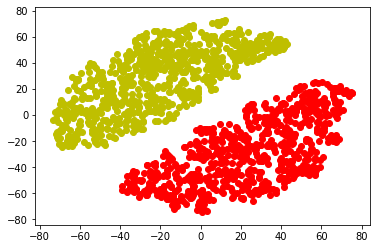

In [0]:
btime_start = time.time()
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'kmeans_preds_sparsity{j}.npy') )
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y_pred_train[i].item())]) 
    if(i%250==0):
      print('.', end = '')
  del tsne
  del y_pred_train
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the KMeans Prediction for Sparsity = {j+1}')
  plt.savefig(os.path.join(kmeans_path,f'predictedKMeans_for_Sparsity_{j+1}.png'))
  plt.clf()

In [0]:
y_pred_train = torch.from_numpy(y_pred_train).type(torch.ByteTensor)#.cuda()
accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')

Gaussian Mixture Model Accuracy = 5.10%


In [0]:
uni = sparse()
(uni[90:96])

torch.Size([39, 1])


tensor([[-1.4063e-01, -2.8145e-01,  4.4411e-01,  5.8321e-02, -2.1524e-01,
          8.6211e-02, -1.0329e-01,  1.2181e-01,  7.2102e-01, -2.8954e-01,
          1.5922e-02,  1.0000e+00,  2.3463e-02, -4.5925e-02, -5.2821e-02,
          3.5522e-01, -1.6904e-04, -4.1855e-01,  1.2959e-01,  3.0241e-01,
         -1.7134e-01, -2.2824e-01, -2.7596e-01, -1.2453e-01, -9.1200e-02,
          1.3983e-01, -2.4867e-01,  4.8624e-02, -1.4572e-01, -9.8532e-02,
          4.0182e-01,  1.1139e-01, -7.1844e-02, -2.2730e-01, -9.3280e-02,
         -6.3991e-01, -9.7520e-02, -3.8303e-01,  4.2248e-01],
        [-6.9391e-01,  3.8642e-01, -3.8027e-01, -4.3062e-01,  3.5098e-01,
         -5.5339e-01,  3.5102e-01, -2.6369e-01, -8.6607e-02, -1.0981e-01,
          2.5792e-01,  1.0000e+00, -1.0263e-01, -1.6609e-01,  2.7656e-01,
          1.4986e-01, -4.4353e-01, -2.9889e-01,  2.4021e-02, -6.1056e-01,
          5.3332e-03,  2.5645e-01,  2.4435e-01, -5.7948e-03, -5.7108e-01,
         -2.6533e-01,  2.5154e-01,  3.0417e-03, -1

## KMeans

In [0]:
kmodel = KMeans(n_clusters = 2, random_state = 42)
y_pred_train = None
time_means_start = time.time()
X = X.cpu()
kmeans = kmodel.fit(X)
print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
y_pred_train = kmeans.labels_
train_accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy = {train_accuracy*100:.2f}%')
print(f'Done time elapsed = {time.time()-time_means_start:.2f}s')

KMeans completed. Time elapsed = 0.18s
KMeans Accuracy = 5.10%
Done time elapsed = 0.18s


.....................................................................................................

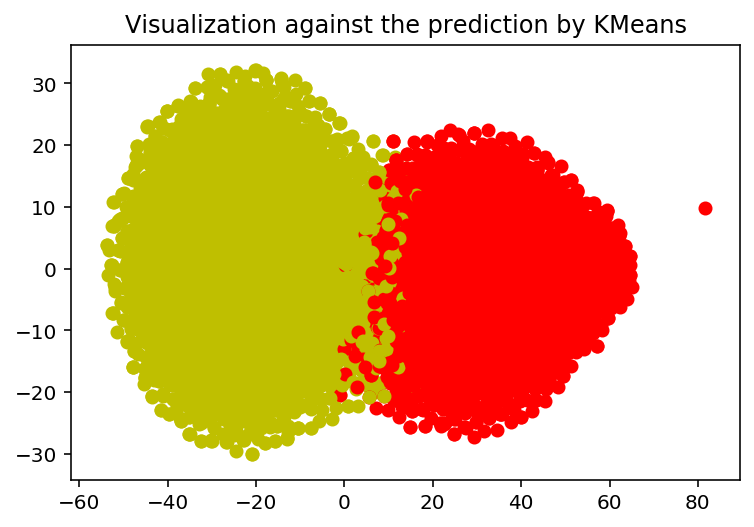

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[kmeans.labels_[i]])
  if(i%100==0):
    print('.', end = '')  
plt.title('Visualization against the prediction by KMeans')
plt.show()

## Autoencoder

In [0]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
  def forward(self, X):
    X = self.fc1(X)
    return X

In [0]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,39),
                             nn.Softmax(dim = 1))
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    X = self.enc(X)
    X = self.dec(X)
    return X

In [0]:
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(enc, dec)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

Autoencoder(
  (enc): encoder(
    (fc1): Sequential(
      (0): Linear(in_features=39, out_features=2, bias=True)
      (1): LogSoftmax()
    )
  )
  (dec): decoder(
    (fc2): Sequential(
      (0): Linear(in_features=2, out_features=39, bias=True)
      (1): Softmax(dim=1)
    )
  )
)

In [0]:
epochs = 600
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
X = X.to(device)

In [0]:
def train():
  
  autoencoder.train()
  train_loss = 0
  
  

  optimizer.zero_grad()

  X_p = autoencoder(X)

  loss = criterion(X_p, X)
  
  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
def test():
  autoencoder.eval()
  test_loss = 0

  with torch.no_grad():

    X_p = autoencoder(X)

    loss = criterion(X_p, X)

    test_loss += loss.item()
  return test_loss

In [0]:
train_loss_list = []
# test_loss_list = []
time_start = time.time()
for e in range(epochs):
  
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

Training done. Time Collapsed =  0.00s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Colla

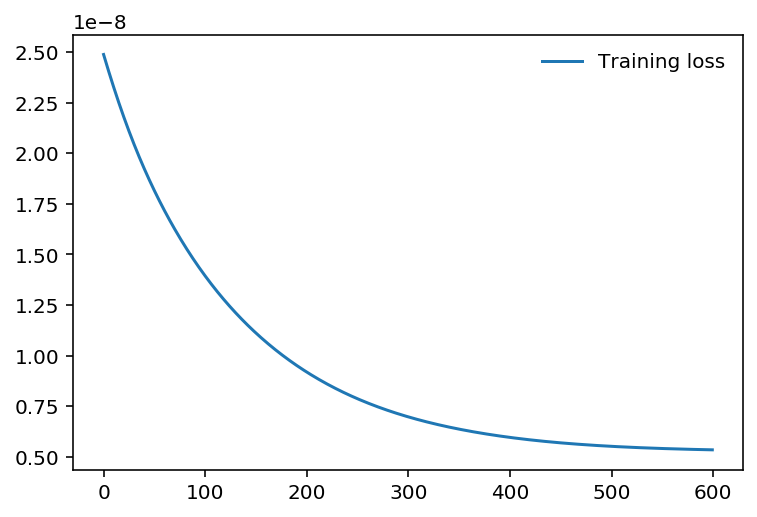

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
# plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

done time elapsed = 63.44s


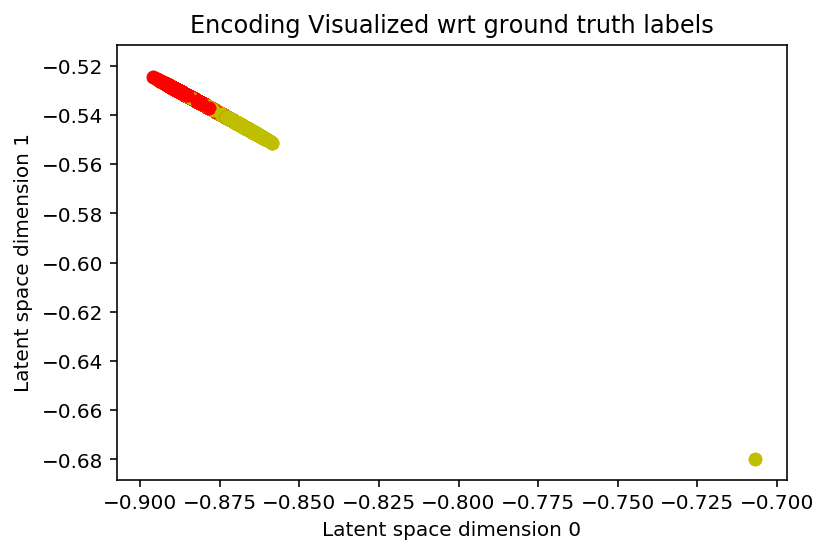

In [0]:
with torch.no_grad():
  enc.eval()
  enc.to(device)
  time_embedding = time.time()
  
  z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  z = z.cpu()
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(labels[i][0].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt ground truth labels')
  plt.show()

In [0]:
y_pred = torch.argmax(z.type(torch.LongTensor), dim = 1)
a = 1 - y_pred.type(torch.ByteTensor).cpu()
labels = labels.cpu()
accuracy = torch.mean((y_pred==labels).type(torch.FloatTensor))
print(f'accuracy = {(accuracy/len(X)*100):.3f}%')

accuracy = 0.005%


In [0]:
1/torch.mean(a.type(torch.FloatTensor))

tensor(10002.)

In [0]:
torch.mean(y_pred.type(torch.FloatTensor))

tensor(0.9999)

done time elapsed = 61.51s


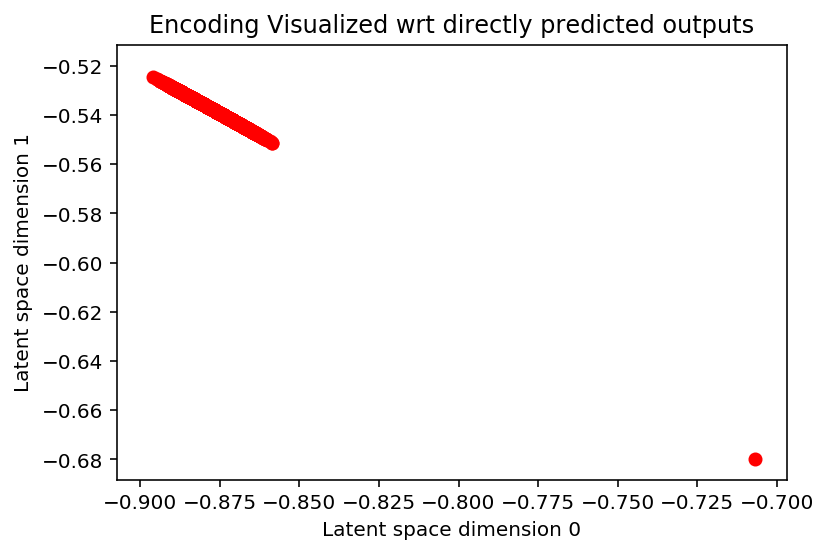

In [0]:
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(y_pred[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt directly predicted outputs')
  plt.show()

In [0]:
z.shape

torch.Size([10002, 2])

done time elapsed = 60.27s


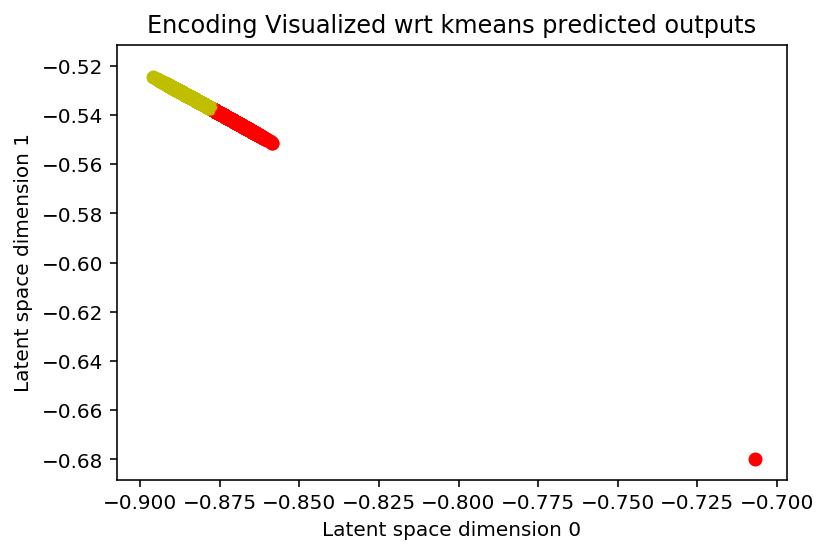

In [0]:
kmeans_auto =  KMeans(n_clusters = 2, random_state = 42)
km = kmeans_auto.fit(z)
kmeans_pred_label = km.labels_
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(kmeans_pred_label[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt kmeans predicted outputs')
  plt.show()

In [0]:
train_accuracy = torch.mean((torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy on Encoding by Autoencoder = {train_accuracy*100:.2f}%')

KMeans Accuracy on Encoding by Autoencoder = 17.44%


In [0]:
np.mean((kmeans_pred_label==np.ones(kmeans_pred_label.shape)).astype('float32'))

0.5

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
wrong_pred_list = []
for i in range(len(kmeans_pred_label)):
  if(kmeans_pred_label[i].item() != labels[i].item()): 
    wrong_pred_list.append(i)
    print(i)
print(len(wrong_pred_list))

10002


In [0]:
torch.sum((torch.from_numpy(kmeans_pred_label) == labels).type(torch.FloatTensor)).item()

50020000.0

In [0]:
zz = (torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002))

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
torch.mean(zz.type(torch.FloatTensor))

tensor(1.)

In [0]:
wrong_pred_list = []
for i,j in enumerate(zz):
  if (not j and (kmeans_pred_labels[i].item() != labels[i].item())):
    wrong_pred_list.append(i)
print(len(wrong_pred_list))

RuntimeError: ignored

In [0]:
zz.shape

torch.Size([10002])

In [0]:
for i,j in enumerate(zz):
  print(j)
  if i >5:
    break


tensor([ True,  True, False,  ...,  True, False,  True])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])


In [0]:
a = torch.randint(low = 0, high = 2, size = (10002,))
b = a.numpy()
c = ((torch.from_numpy(b) == a).type(torch.FloatTensor))
print(c)

tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [0]:
c.shape

torch.Size([10002])

In [0]:
nn.Flatten()(labels).shape

torch.Size([10002, 1])

## VAE

In [0]:
class encoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.mu = nn.Sequential(nn.Linear(39, 500),nn.ReLU(),
                            nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 2000), nn.ReLU(),
                            nn.Linear(2000,2),nn.ReLU())
    self.var = nn.Sequential(nn.Linear(39, 500), nn.ReLU(),
                            nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 2000), nn.ReLU(),
                            nn.Linear(2000,2),nn.ReLU())
  def forward(self, X):
    z_mu = self.mu(X)
    z_var = self.var(X)
    return z_mu, z_var

In [0]:
class decoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,2000),nn.ReLU(),
                             nn.Linear(2000, 500), nn.ReLU(),
                             nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 39), nn.ReLU())                            
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class VAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    z_mu, z_var = self.enc(X)
    std = torch.exp( z_var/2 )
    eps = torch.randn_like(std)
    z_sample = eps.mul(std).add_(z_mu)
    X_predic = self.dec(z_sample)
    return X_predic, z_mu, z_var

In [0]:
enc_v = encoder_v()
dec_v = decoder_v()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vautoencoder = VAutoencoder(enc_v, dec_v).to(device)
optimizer = torch.optim.Adam(vautoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
sensitivity = 100
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_variance_{1/sensitivity:.2f}.npy'))
X = torch.Tensor(X)
X= X.to(device)

In [0]:
def train():
  
  vautoencoder.train()
  train_loss = 0
  

  optimizer.zero_grad()

  X_pred, z_mu, z_var = vautoencoder(X)

  recon_loss = criterion(X_pred, X)
  kl_loss = 0.5*( torch.sum( torch.exp(z_var) + z_mu**2 - 1.0 + z_var ) ) 
  loss = recon_loss + kl_loss

  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
# def test():
#   vautoencoder.eval()
#   test_loss = 0

#   with torch.no_grad():

#     X_ped, z_mu, z_var = vautoencoder(images)

#     recon_loss = criterion(X, images)
#     kl_loss = 0.5*torch.sum(torch.exp(z_var)+ z_mu**2 - 1 + z_var)
#     loss = recon_loss + kl_loss

#     test_loss += loss.item()      
#   return test_loss

In [0]:
epochs = 30

In [0]:
train_loss_list = []
test_loss_list = []
time_start = time.time()
for e in range(epochs):
  print(f'{e+1}th epoch...')
  print(f'Training...')
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

1th epoch...
Training...
Training done. Time Collapsed =  0.20s
2th epoch...
Training...
Training done. Time Collapsed =  0.37s
3th epoch...
Training...
Training done. Time Collapsed =  0.54s
4th epoch...
Training...
Training done. Time Collapsed =  0.69s
5th epoch...
Training...
Training done. Time Collapsed =  0.84s
6th epoch...
Training...
Training done. Time Collapsed =  0.99s
7th epoch...
Training...
Training done. Time Collapsed =  1.14s
8th epoch...
Training...
Training done. Time Collapsed =  1.30s
9th epoch...
Training...
Training done. Time Collapsed =  1.44s
10th epoch...
Training...
Training done. Time Collapsed =  1.59s
11th epoch...
Training...
Training done. Time Collapsed =  1.74s
12th epoch...
Training...
Training done. Time Collapsed =  1.88s
13th epoch...
Training...
Training done. Time Collapsed =  2.03s
14th epoch...
Training...
Training done. Time Collapsed =  2.18s
15th epoch...
Training...
Training done. Time Collapsed =  2.33s
16th epoch...
Training...
Training

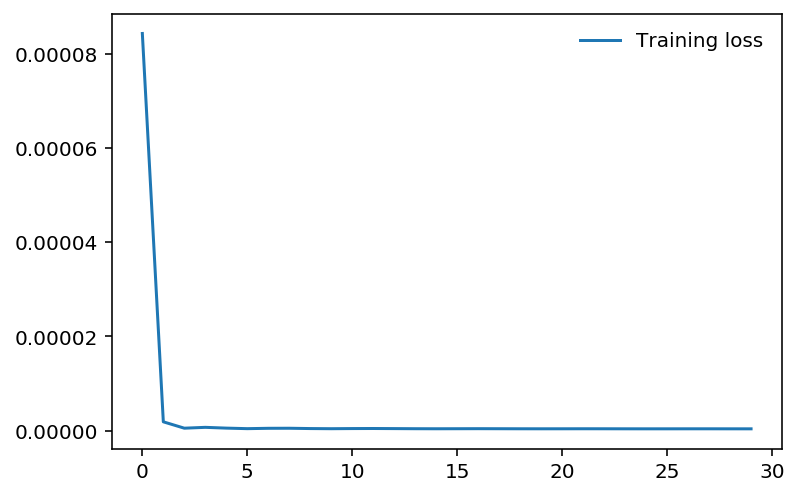

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
plt.legend(frameon=False)

In [0]:
X.shape

torch.Size([10002, 39])

In [0]:
encoding,_ = enc_v(X)
encoding = encoding.cpu().detach()
encoding.shape


torch.Size([10002, 2])

In [0]:
labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_variance_{1/sensitivity:.2f}.npy'))
labels = torch.Tensor(labels)

100%|██████████| 10002/10002 [01:28<00:00, 113.39it/s]


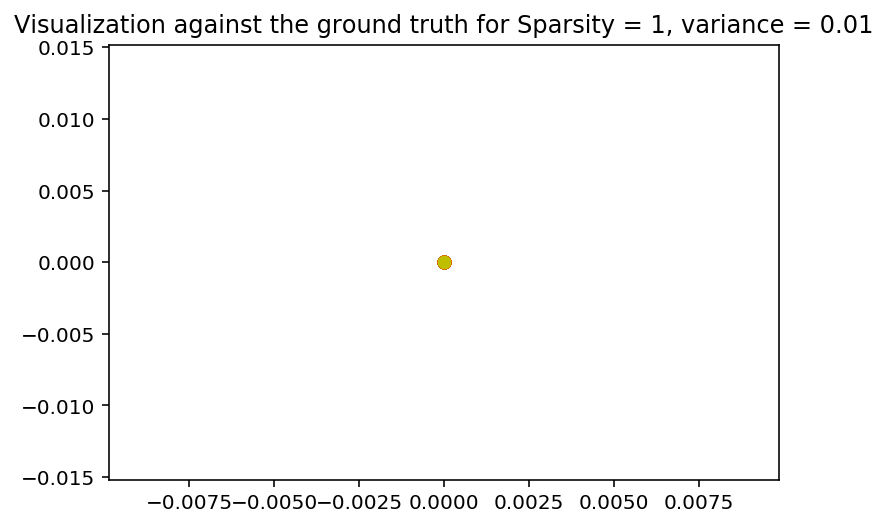

In [0]:
for i in tqdm(range(len(encoding))):
  plt.scatter(encoding[i][0], encoding[i][1], c=colors[int(labels[i].item())])  
plt.title(f'Visualization against the ground truth for Sparsity = 1, variance = {1/sensitivity:.2f}')
plt.savefig(os.path.join(synthetic_path,f'v_encoding_ground_truth_Sparsity_1_variance_{1/sensitivity:.2f}.png'))

# DEC

In [0]:

  autoencoder, encoder = autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  fits = autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  # autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}.h5"))
  encoding = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'), encoding) 
  #============#
  clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer=Adam(0.01), loss='kld')
  k_means = KMeans(n_clusters=2, n_init=20)
  y_pred_ae = k_means.fit_predict(encoding) 
  y_pred_last = np.copy(y_pred_ae)
  model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  #===================#
  loss = 0
  index = 0
  maxiter = 8000
  update_interval = 140
  index_array = np.arange(X.shape[0])
  tol = 0.001 
  acc = 0
  #=====================#
  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(X, verbose=0)
          p = target_distribution(q) 
          y_pred_ae = q.argmax(1)
          print(y_pred_ae.shape)
          print(labels.numpy().shape)
          if labels.numpy() is not None:
              acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
              nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
              ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
              loss = np.round(loss, 5)
              print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
          delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
          y_pred_last = np.copy(y_pred_ae)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
      loss = model.train_on_batch(x=X[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  accuracy_dec_list.append(acc)
  # model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_db{db}.h5'))
  encoded_dec = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_db_{db}.npy'), encoded_dec)
  # del encoding, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

Epoch 1/30
10002/10002 [==============================] - 2s 174us/step - loss: 0.1020
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0052
Epoch 3/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 4/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0048
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 6/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0034
Epoch 7/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0027
Epoch 8/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0031
Epoch 10/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 11/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0025
Epoch 12/30
10002/10002 [==========================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.98170, nmi = 0.88624, ari = 0.92815  ; loss= 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.98130, nmi = 0.88433, ari = 0.92661  ; loss= 0.0
delta_label  0.0009998000399920016 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


<function matplotlib.pyplot.show>

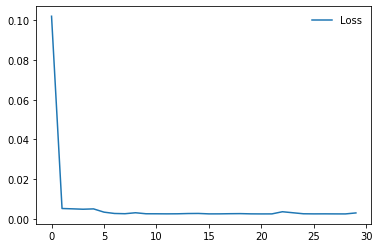

In [0]:
plt.plot(fits.history['loss'], label = 'Loss')
plt.legend(frameon = False)
plt.show